# SLIC
In this question , our goal is to divide image to super pixels using SLIC algorithm .
we will say further  how to implement SLIC


# Theory :
to segment our image to N cluster using SLIC, first we initialize cluster centers and then perturb them based on the gradian of image in lab domain !

after perturbing cluster's centers , we have to find total distance for all of the pixels . total distance is defined by :
$total-distance=d_{lab}+\alpha d_{xy}$ where lab distance is a distance between lab values of pixel and xy distance is euclidean distance between pixels.

after calculating total distance we relate a cluster to each pixels (exactly like k_means segmentation). and repeat this procedure until clusters for each pixels don't change anymore .

* the tricky points about this procedure is that we have to optimize our method by vectoring instead of using for loops . for that we use `np.indices` to speed up our code for calculating $d_{xy}$

below is the summarize of this algorithm :
we will explain further each part of algorithm more specifically

### Import required libraries

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import math
import skimage.segmentation
import scipy.signal

### Gradient of Image

In [3]:
def gradians(mat):

    result = np.array(ndimage.sobel(mat))

    return result


### Find Euclidean_distance


In [4]:
def euclidean_distance(x: np.ndarray, y: np.ndarray, x_i, y_i):

    dxy = np.sqrt((x-x_i)**2+(y-y_i)**2)

    return dxy


### LAB_distance

In [5]:
def lab_distance(lab: np.ndarray, l_i, a_i, b_i):

    l = lab[:, :, 0]
    a = lab[:, :, 1]
    b = lab[:, :, 2]

    dlab = np.sqrt((l-l_i)**2+(a-a_i)**2+(b-b_i)**2)

    return dlab



### Initiate Centers of Clusters



In [6]:
def initial_centrid(k, original_image: np.ndarray, c1, c2):

    each_dim = int(math.sqrt(k))

    dis1 = c1//each_dim
    num1 = c1//dis1
    dis2 = c2//each_dim
    num2 = c2//dis2

    s_total = max(dis1, dis2)
    k = num1*num2

    x = []
    y = []
    # inital centroids
    for g in range(0, num1):
        for h in range(0, num2):
            x.append(dis1//2+g*dis1)
            y.append(dis2//2+h*dis2)

    return np.array(x), np.array(y), s_total, k

# ------------------------------------
def perturb_clusters_centers(x: np.ndarray, y: np.ndarray, s, k, c1, c2, edge):

    # perturb clusters centers
    for i in range(0, k):

        point = np.where(edge[max(x[i]-2, 0):min(x[i]+2, c1-1), max(y[i]-2, 0):min(y[i]+2, c2-1)]
                         == np.min(edge[max(x[i]-2, 0):min(x[i]+2, c1-1), max(y[i]-2, 0):min(y[i]+2, c2-1)]))

        x[i] = x[i]+point[0][0]-2
        y[i] = y[i]+point[1][0]-2

    return x, y, s, k



after initializing cluster's center we pass the proper arguments to `slic_seg()` to calculate Best cluster centers for each pixel .
after labeling each pixel. we face some difficulty:
some close points had different boarders so when we plotted the boarders , it didn't have good picture. so we use `filter2d.median()` to solve this problem . in addition we use `find_boundaries()` to find boundaries and plot them .

In [7]:
def slic_seg(x, y, k, s, image: np.ndarray, lab_image: np.ndarray):

    [c1, c2, c3] = image.shape

    scores = np.zeros([c1, c2])

    compare_matrix = np.ones([c1, c2])*1000000

    i_mat, j_mat = np.indices((c1, c2))

    for w in range(0, k):

        i = x[w]
        j = y[w]
        # ------------
        lab_temp = lab_image[max(
            i-s, 0):min(i+s, c1), max(j-s, 0):min(j+s, c2), :]

        lab_dis = lab_distance(
            lab_temp, lab_image[i, j, 0], lab_image[i, j, 1], lab_image[i, j, 2])
        # ------------
        xy_dis = euclidean_distance(
            i_mat[max(i-s, 0):min(i+s, c1), max(j-s, 0):min(j+s, c2)], j_mat[max(i-s, 0):min(i+s, c1), max(j-s, 0):min(j+s, c2)], i, j)

        # -------------

        total_dis = lab_dis+0.1*xy_dis

        x_f, y_f = np.where(total_dis[:, :] <= compare_matrix[max(
            i-s, 0):min(i+s, c1), max(j-s, 0):min(j+s, c2)])

        compare_matrix[max(i-s, 0)+x_f, max(j-s, 0) +
                       y_f] = total_dis[x_f, y_f]

        scores[max(i-s, 0)+x_f, max(j-s, 0)+y_f] = w

    return scores


### Find Boundaries

In [8]:

def borders(score_mat, imagee):

    scores = scipy.signal.medfilt2d(score_mat[:, :], 29)

    borders = skimage.segmentation.find_boundaries(
        np.uint8(scores), mode='outer', connectivity=0.5).astype(bool)

    x, y = np.where(borders == 1)
    img = np.copy(imagee)
    img[x, y, :] = 0

    return img


### Find Best Parameter($\alpha$)
as we discussed before we have :

$total-distance=d_{lab}+\alpha d_{xy}$

and $\alpha$ determine sensitivity of our segmentation .
as $\alpha$ goes up , clusters have more regular shape and clusters do not exceed their initial aria . as $\alpha$ goes down clusters have irregular shape and exceed their aria . in this question i set the $\alpha=0.1$ .


below you can see the result for different numbers of cluster

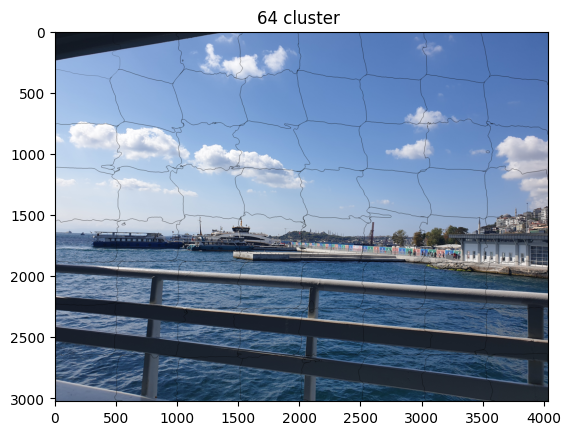

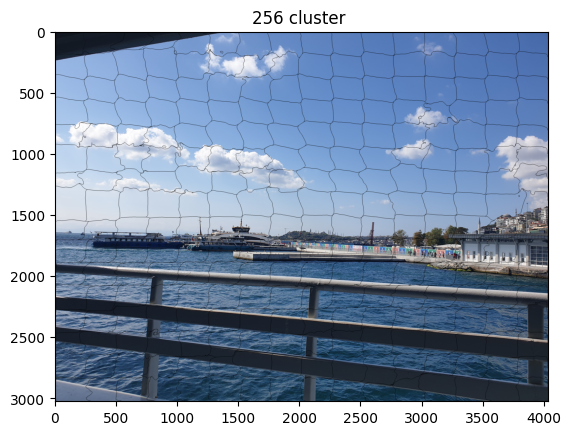

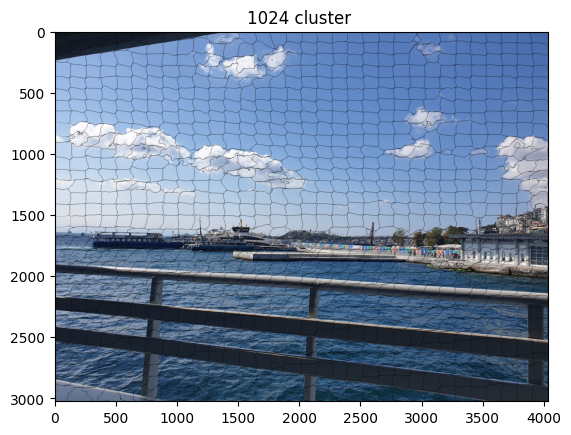

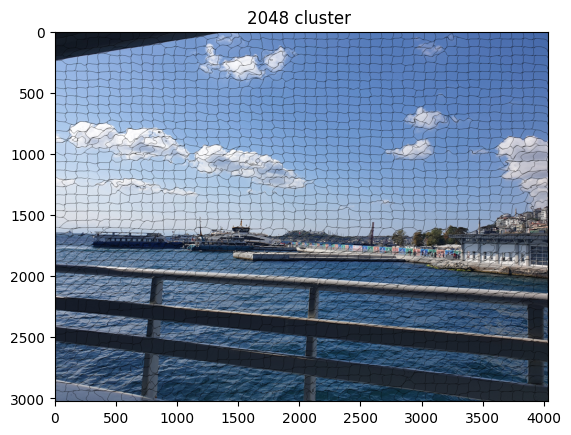

In [9]:
original_image = cv2.imread('/content/slic.jpg')
original_image = np.array(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
lab_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2Lab)

[c1, c2, c3] = original_image.shape

edge = gradians(gray_image)

for g in range(1, 5):

    k = 64*(4**(g-1))
    if(g == 4):
        k = 2048

    x, y, s, k = initial_centrid(k, original_image, c1, c2)

    x, y, s, k = perturb_clusters_centers(x, y, s, k, c1, c2, edge)



    scores = slic_seg(x, y, k, s, original_image, lab_image)
    result = borders(scores, original_image)

    k = 64*(4**(g-1))
    if(g == 4):
        k = 2048

    plt.imsave(f'res0{g+5}.jpg', result)
    plt.imshow(result)
    plt.title(f'{k} cluster ')
    plt.show()
